In [3]:

# Imports
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import random


In [4]:
#setting seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [5]:
# Load the dataset
df = pd.read_csv("D:/Projects/DL_gtzan/data/features_3_sec.csv")

# Drop rows with missing values (if any)
df.dropna(inplace=True)

#  Separate features and labels
X = df.drop(columns=['filename', 'label'])
y = df['label']

#  Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [6]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_encoded, dtype=torch.long)

# Split into train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.3, stratify=y_tensor, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Optional: Print shape
print("X_train:", X_train.shape, "y_train:", y_train.shape)


X_train: torch.Size([6993, 58]) y_train: torch.Size([6993])


In [7]:
# Define Autoencoder Architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim=58, bottleneck_dim=128):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, bottleneck_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        return self.encoder(x)


In [8]:
# Initialize model, optimizer, loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder(input_dim=58, bottleneck_dim=128).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

# Create DataLoader
batch_size = 128
train_dataset = TensorDataset(X_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Pretrain Autoencoder
num_epochs = 100
for epoch in range(num_epochs):
    autoencoder.train()
    epoch_loss = 0
    for batch in train_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        output = autoencoder(x)
        loss = criterion(output, x)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss/len(train_loader):.4f}")


Epoch 1/100 | Loss: 0.5206
Epoch 2/100 | Loss: 0.2168
Epoch 3/100 | Loss: 0.1289
Epoch 4/100 | Loss: 0.0826
Epoch 5/100 | Loss: 0.0543
Epoch 6/100 | Loss: 0.0383
Epoch 7/100 | Loss: 0.0287
Epoch 8/100 | Loss: 0.0231
Epoch 9/100 | Loss: 0.0196
Epoch 10/100 | Loss: 0.0174
Epoch 11/100 | Loss: 0.0160
Epoch 12/100 | Loss: 0.0147
Epoch 13/100 | Loss: 0.0138
Epoch 14/100 | Loss: 0.0129
Epoch 15/100 | Loss: 0.0120
Epoch 16/100 | Loss: 0.0116
Epoch 17/100 | Loss: 0.0108
Epoch 18/100 | Loss: 0.0105
Epoch 19/100 | Loss: 0.0101
Epoch 20/100 | Loss: 0.0098
Epoch 21/100 | Loss: 0.0091
Epoch 22/100 | Loss: 0.0086
Epoch 23/100 | Loss: 0.0084
Epoch 24/100 | Loss: 0.0078
Epoch 25/100 | Loss: 0.0078
Epoch 26/100 | Loss: 0.0076
Epoch 27/100 | Loss: 0.0074
Epoch 28/100 | Loss: 0.0074
Epoch 29/100 | Loss: 0.0068
Epoch 30/100 | Loss: 0.0066
Epoch 31/100 | Loss: 0.0062
Epoch 32/100 | Loss: 0.0059
Epoch 33/100 | Loss: 0.0058
Epoch 34/100 | Loss: 0.0059
Epoch 35/100 | Loss: 0.0056
Epoch 36/100 | Loss: 0.0057
E

In [9]:
# Set the autoencoder model to evaluation mode (disables dropout, etc.)

autoencoder.eval()
with torch.no_grad():
    X_train_encoded = autoencoder.encode(X_train.to(device)).cpu()
    X_val_encoded = autoencoder.encode(X_val.to(device)).cpu()
    X_test_encoded = autoencoder.encode(X_test.to(device)).cpu()

print(X_train_encoded.shape)  


torch.Size([6993, 128])


In [10]:
#  Classifier model on encoded features
#  Deep Classifier with regularization
class GenreClassifier(nn.Module):
    def __init__(self, input_dim=128, num_classes=10):  # Updated input_dim
        super(GenreClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.model(x)


# Initialize
classifier = GenreClassifier(input_dim=128).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001, weight_decay=1e-5)  # L2 regularization

# DataLoaders
train_ds = TensorDataset(X_train_encoded, y_train)
val_ds = TensorDataset(X_val_encoded, y_val)
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=128)


In [17]:

history = {'total_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# Training loop
for epoch in range(100):
    classifier.train()
    total_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = classifier(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    classifier.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            preds = classifier(xb)
            predicted = preds.argmax(dim=1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
        acc = correct / total

    print(f"Epoch {epoch+1}/100 | Train Loss: {total_loss:.4f} | Val Accuracy: {acc*100:.2f}%")
    
    history['total_loss'].append(total_loss)
    history['val_loss'].append(acc*100)
    

Epoch 1/100 | Train Loss: 45.0206 | Val Accuracy: 74.10%
Epoch 2/100 | Train Loss: 42.7883 | Val Accuracy: 78.77%
Epoch 3/100 | Train Loss: 40.0225 | Val Accuracy: 78.84%
Epoch 4/100 | Train Loss: 39.7112 | Val Accuracy: 80.64%
Epoch 5/100 | Train Loss: 37.7980 | Val Accuracy: 80.04%
Epoch 6/100 | Train Loss: 36.2358 | Val Accuracy: 79.44%
Epoch 7/100 | Train Loss: 34.9063 | Val Accuracy: 78.37%
Epoch 8/100 | Train Loss: 34.3406 | Val Accuracy: 79.91%
Epoch 9/100 | Train Loss: 33.5757 | Val Accuracy: 82.04%
Epoch 10/100 | Train Loss: 33.2752 | Val Accuracy: 83.18%
Epoch 11/100 | Train Loss: 32.3124 | Val Accuracy: 81.24%
Epoch 12/100 | Train Loss: 31.3419 | Val Accuracy: 82.44%
Epoch 13/100 | Train Loss: 29.5701 | Val Accuracy: 82.78%
Epoch 14/100 | Train Loss: 30.3851 | Val Accuracy: 82.98%
Epoch 15/100 | Train Loss: 29.2032 | Val Accuracy: 81.71%
Epoch 16/100 | Train Loss: 29.0158 | Val Accuracy: 80.97%
Epoch 17/100 | Train Loss: 27.8347 | Val Accuracy: 84.25%
Epoch 18/100 | Train Lo

              precision    recall  f1-score   support

       blues       0.88      0.88      0.88       150
   classical       0.87      0.99      0.93       150
     country       0.87      0.79      0.83       149
       disco       0.90      0.76      0.82       150
      hiphop       0.83      0.90      0.87       150
        jazz       0.94      0.84      0.89       150
       metal       0.88      0.95      0.91       150
         pop       0.88      0.89      0.89       150
      reggae       0.86      0.92      0.89       150
        rock       0.81      0.79      0.80       150

    accuracy                           0.87      1499
   macro avg       0.87      0.87      0.87      1499
weighted avg       0.87      0.87      0.87      1499



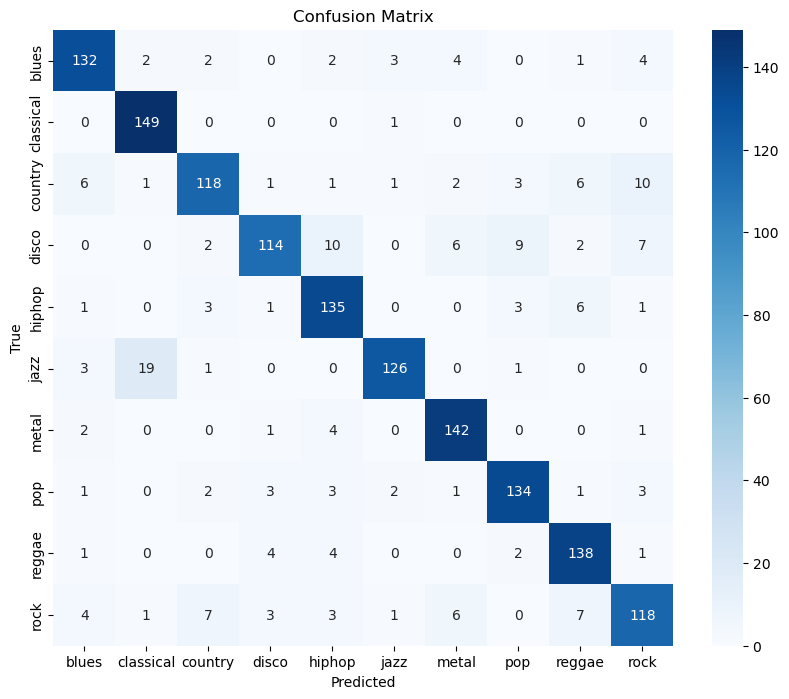

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get test predictions
classifier.eval()
with torch.no_grad():
    test_preds = classifier(X_test_encoded.to(device)).argmax(dim=1).cpu().numpy()
    test_true = y_test.numpy()

# Classification report
print(classification_report(test_true, test_preds, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(test_true, test_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [19]:
save_path = r"D:\Projects\DL_gtzan\models\MLP_autoencoders\autoencoder_mlp_weights.pth"
torch.save(model.state_dict(), save_path)


NameError: name 'model' is not defined

In [22]:
def evaluate_metrics(model, dataloader, device, class_names):
    """
    Runs the model on dataloader, prints classification report,
    and returns the confusion matrix.
    
    model:         trained torch.nn.Module
    dataloader:    DataLoader for the split you want to evaluate
    device:        torch.device('cuda' or 'cpu')
    class_names:   list of label names in order
    """
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    # Classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("=== Classification Report ===\n", report)
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    return cm

def plot_confusion_matrix(cm, class_names):
    """
    Plots a confusion matrix using Matplotlib.
    cm:           numpy array of shape (n_classes, n_classes)
    class_names:  list of label strings
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
    plt.yticks(np.arange(len(class_names)), class_names)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

def plot_training_history(history):
    """
    history: dict with keys 'total_loss', 'val_loss'
             each mapping to a list of length num_epochs
    """
    epochs = range(1, len(history['total_loss']) + 1)

    # Loss curves
    plt.figure()
    plt.plot(epochs, history['total_loss'])
    plt.plot(epochs, history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Val'])
    plt.title('Training vs. Validation Loss')
    plt.show()

   

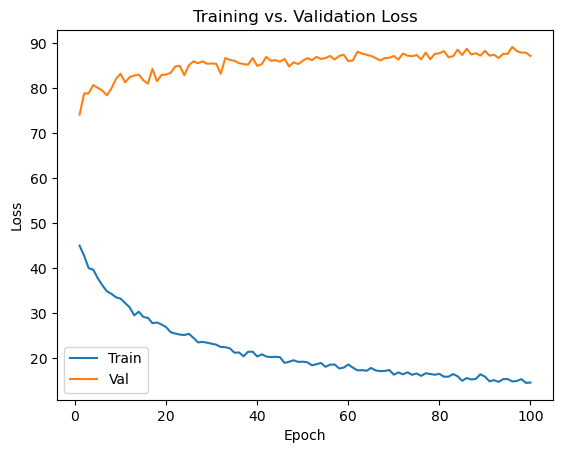

In [24]:
# 1) Plot loss & accuracy curves
plot_training_history(history)


